# Identify working and data directory and site ID.
* The working directory is the root directory of the github.
* The data directory points to the google drive folder where the larger data files are stored.
* For the moment the site ID if the four-digit NEON site ID.

In [ ]:
working<-"~/neon_suna"
site_id<-"SUGG"
#data<-paste("~/gdrive/SUNA_Data/SUNA_NEON/",site_id,"/2019",sep="")
data<-"/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/SUGG_2019"

# Initialize required libraries, functions and formatting utilities.

In [ ]:
library(dplyr)
library(streamMetabolizer)
library(splitstackshape)
library(ggplot2)
library(lubridate)
library(reshape2)
library(neonUtilities)
library(progress)
library(patchwork)
library(doBy)
library(stringr)
#library(box)

theme_ts_space<-theme_grey() +
		theme(
#		panel.grid.major = element_blank(),
#		panel.grid.minor = element_blank(),
		panel.background = element_rect(fill="white", colour="black", size=2),
#		legend.key       = element_blank(),
#		legend.text      = element_text(size=20.5),
#		legend.text      = element_blank(),
#		legend.title     = element_text(size=20.5),
		axis.text.x = element_text(size=22,colour="black",hjust=1,angle=45),
		axis.text.y = element_text(size=22,colour="black",vjust=.3),
		axis.title.x = element_text(size=22),
		axis.title.y = element_text(size=22,vjust=-1),
#		plot.title = element_text(hjust = 0.5,size=22,face="bold"),		
#		legend.position  = "left",
		legend.position  = "none",
		plot.margin = unit(c(1,1,1,1), "cm"),
		panel.border = element_rect(colour = "black", fill=NA, size=2)
		)





# Setting up the workspace
In the cell below indicate the site that will be analyzed here according to its NEON 4-letter code. A list of files for that site is then placed in the vector "sunas".

If you downloaded the repo into your home director, which is found by going to "~/", then you don"t have to change the box path. FYI: Box is a new package for R that allows you to define a set of functions without creating a new package.

In [ ]:

#setwd(paste("~/gdrive/SUNA_data/SUNA_NEON/",site_id,sep=""))
#sunas<-list.files(pattern="*.csv")
#getwd()
#options(box.path = "~/neon_suna/box/")
#box::use(plots)

setwd(data)
sunas<-list.files(pattern="*.CSV")

#suna_cal<-readRDS("/Users/jhosen/gdrive/fdom/SUNA Calibration pdfs/suna_cal_comb.rds")
suna_cal<-read.csv("/Users/jhosen/gdrive/SUNA_Data/SUNA Calibration pdfs/suna_0839_20200312.csv")
suna_cal_t<-as.data.frame(t(suna_cal))
names(suna_cal_t)<-suna_cal_t[1,]

# Data import and processing loop.
This step loads each data file, formats the data for use, and concatenates files from an individual site.

This step could take a while.

In [ ]:
cal

In [ ]:
options(warn=-1)
compiled_suna<-data.frame()
sunas_length<-length(sunas)
for(i in 1:sunas_length){
#i<-1
print(i)


suna_calid<-read.csv(paste(sunas[i]),skip=0,header=FALSE)
cal<-str_extract(suna_calid,"[SNA]{3}[0-9]{4}[a-zA-Z]{1}")
cal<-cal[!is.na(cal)]
    
    
suna<-read.csv(paste(sunas[i]),skip=30,header=FALSE)

if(cal!="SNA0564Q" & cal!="SNA0564R" & cal!="SNA0564S"){suna_cal<-read.csv(paste("/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/SUGG_2019/cal_files/",cal,"_abbr.csv",sep=""))}else{
    suna_cal<-read.csv("/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/SUGG_2019/cal_files/SNA0564T_abbr.csv")}

suna_cal_t<-as.data.frame(t(suna_cal))
names(suna_cal_t)<-suna_cal_t[1,]

#suna_d0<-cSplit(suna,3, ",")
names(suna)<-c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","int_time",suna_cal$wavelength_nm,"sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum")

    
#suna<-subset(suna,a254!=0)

suna<-subset(suna,a254!=0)
    
#year<-substr(suna$date, 1, 4)
if(grepl("D2019",sunas[i])==TRUE){
year<-"2019"
doy<-gsub(".CSV","",gsub("D2019","",paste(sunas[i]),fixed=TRUE),fixed=TRUE)
}
    
if(grepl("D2020",sunas[i])==TRUE){
year<-"2020"
doy<-gsub(".CSV","",gsub("D2020","",paste(sunas[i]),fixed=TRUE),fixed=TRUE)
}

day<-as.POSIXct(paste(as.Date(as.numeric(doy)-1,origin=paste(year,"-01-01",sep="")),"00:00:00"),tz="UTC")
#suna$day<-as.POSIXct("2019-05-10 00:00:00",tz="UTC")
suna$dtp<-day + (3600*as.numeric(suna$time))
#attr(suna$dtp,"tzone") <- "Etc/GMT+8"

    

offse<-c(t(suna_cal_t[3,]))
suna2<-(suna[,12:267]/suna$int_time)-suna$dark_signal_average
suna_d0_norm<-sweep(suna2,2,FUN="/",offse)
names(suna_d0_norm)<-paste("n_",names(suna_cal_t),sep="")

    

#print("test")
suna_d0_int<-data.frame()
for(j in 1:nrow(suna_d0_norm)){	
#    print(j)
	flip<-as.data.frame(t(suna_d0_norm[j,]))
	names(flip)<-c("abs")
	flip$wl_nm<-gsub("n_","",row.names(flip),fixed=TRUE)
	flip_int<-as.data.frame(t(approx(flip$wl_nm,flip$abs,xout=seq(189,394,1),rule=2)$y))
	names(flip_int)<-paste("interp_",seq(189,394,1),sep="")
	suna_d0_int<-bind_rows(suna_d0_int,flip_int)
}
suna_d<-bind_cols(suna,suna_d0_int)
#suna_d$date<-as.character(suna_d[,c("date")])
#suna_d$time<-as.character(suna_d[,c("time")])
suna_d2<-suna_d %>% mutate_if(is.numeric,as.character)
compiled_suna<-bind_rows(compiled_suna,suna_d2)
}
print("done")
options(warn=0)    
    
    
    


# Check Data and Save

In [ ]:
#head(compiled_suna)
#grepl("D2020",sunas[240])
#sunas[240]
#length(sunas)
#sunas[240]
#ncol(compiled_suna)
#nrow(compiled_suna)
#names(compiled_suna)<-gsub("inter_time","int_time",names(compiled_suna),fixed=TRUE)
#saveRDS(compiled_suna,"/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/SUGG_2019/SUGG_corrected/SUNA_SUGG_20210428_full.rds")
compiled_suna<-readRDS("/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/SUGG_2019/SUGG_corrected/SUNA_SUGG_20210428_full.rds")


# Extracting the interpolated columns

In [ ]:
compiled_suna$cal<-"suna_0839"

suna_interp<-compiled_suna[,grepl("^inter",names(compiled_suna))] %>% mutate_if(is.character, ~as.numeric(.))
#head(suna_interp)

other_suna<-compiled_suna[,c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","int_time","sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum","cal","dtp")]

suna_cols<-bind_cols(other_suna,suna_interp)
suna_cols$a254<-as.numeric(suna_cols$a254)
suna_cols$a350<-as.numeric(suna_cols$a350)
suna_cols$nitrate<-as.numeric(suna_cols$nitrate)
suna_cols$nitrate_mgl<-as.numeric(suna_cols$nitrate_mgl)
suna_cols$sensor_temp<-as.numeric(suna_cols$sensor_temp)


In [ ]:
range(suna_cols$a254)
range(suna_cols$interp_254)

In [76]:
suna_cols<-subset(suna_cols,a350<10 & a254<10)
a350_mod<-lm(a350~log10(interp_350)+I(log10(interp_350)^2)+I(log10(interp_350)^3),suna_cols)
a254_mod<-lm(a254~log10(interp_254+0.6)+I(log10(interp_254+0.6)^2)+I(log10(interp_254+0.6)^3),suna_cols)



cor_cols<-grep("^interp_",names(suna_cols))


Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”



Call:
lm(formula = a254 ~ log10(interp_254 + 0.6) + I(log10(interp_254 + 
    0.6)^2) + I(log10(interp_254 + 0.6)^3), data = suna_cols)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.90612 -0.16805  0.02262  0.16564  2.49449 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   2.185545   0.001823 1198.65   <2e-16 ***
log10(interp_254 + 0.6)      -2.913060   0.007043 -413.59   <2e-16 ***
I(log10(interp_254 + 0.6)^2) -4.398466   0.011833 -371.73   <2e-16 ***
I(log10(interp_254 + 0.6)^3) -1.023596   0.014579  -70.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2487 on 416897 degrees of freedom
Multiple R-squared:  0.4373,	Adjusted R-squared:  0.4373 
F-statistic: 1.08e+05 on 3 and 416897 DF,  p-value: < 2.2e-16


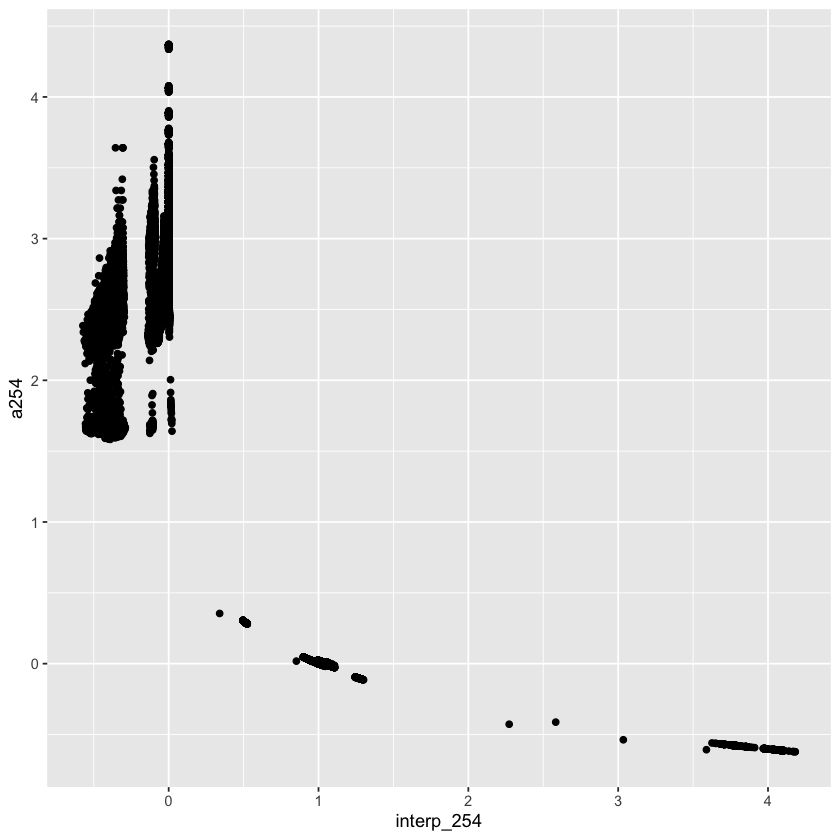

In [77]:
ggplot(suna_cols,aes(interp_254,a254))+geom_point()

summary(a254_mod)

In [ ]:

#compiled_suna2[,c(cor_cols)]<-compiled_suna2[,c(cor_cols)] %>% mutate_if(is.character,as.numeric)

for(i in 1:length(cor_cols)){
	prepdata<-data.frame(interp_350=suna_cols[,cor_cols[i]],interp_254=suna_cols[,cor_cols[i]])
	a350_pred<-predict(a350_mod,newdata=prepdata)
	a254_pred<-predict(a254_mod,newdata=prepdata)
	suna_cols[,c(paste(names(suna_cols)[cor_cols[i]],"_c350",sep=""))]<-a350_pred
	suna_cols[,c(paste(names(suna_cols)[cor_cols[i]],"_c254",sep=""))]<-a254_pred
}



# Reducing data down to 15 minutes intervals.
We want to average down each burst from the SUNA to a single value and mac sure that these values are snapped to 15 minutes intervals (e.g., rather than round up or down to 14 or 16).

In [81]:
head(suna_cols)

[1] 416901

In [82]:
#rm(compiled_suna)
#rm(compiled_suna_1)
#rm(compiled_suna_2)

suna_cols$dtpr<-lubridate::round_date(suna_cols$dtp, "15 minutes")
suna_red<-summaryBy(.~dtpr,suna_cols,FUN=c(mean))



In [ ]:
#unique(as.Date(suna_red$dtpr))

# Downloading turbidity time series data from NEON.
Data product DP1.20288.001 for general water quality sonde data.

In [83]:
#SUGG_wqs<-loadByProduct(dpID="DP1.20288.001",site="SUGG",check.size=F)
#saveRDS(SUGG_wqs,paste(data,"/SUGG_wqs.rds",sep=""))
SUGG_wqs<-readRDS(paste(data,"/SUGG_wqs.rds",sep=""))


In [84]:
SUGG_wqsd<-SUGG_wqs$waq_instantaneous
SUGG_wqsd$dtp<-SUGG_wqsd$startDateTime
SUGG_wqk<-subset(SUGG_wqsd[,c("siteID","dtp","specificConductance","dissolvedOxygen","pH","chlorophyll","turbidity","fDOM")],!is.na(SUGG_wqsd$specificConductance))
#str(SUGG_wqk)

SUGG_wqk$dtpr<-lubridate::round_date(SUGG_wqk$dtp, "15 minutes")
SUGG_wq_red<-summaryBy(.~dtpr,SUGG_wqk,FUN=c(mean))
str(SUGG_wq_red)

'data.frame':	94947 obs. of  7 variables:
 $ dtpr                    : POSIXct, format: "2017-12-14 17:45:00" "2017-12-14 18:00:00" ...
 $ specificConductance.mean: num  64 64 63.9 64 64 ...
 $ dissolvedOxygen.mean    : num  6.09 5.99 5.99 6 5.99 ...
 $ pH.mean                 : num  4.77 4.76 4.76 4.75 4.75 ...
 $ chlorophyll.mean        : num  31.3 31.3 31.4 31.3 31.4 ...
 $ turbidity.mean          : num  -2.87 -2.83 -2.82 -2.78 -2.76 ...
 $ fDOM.mean               : num  NA NA NA NA NA NA NA NA NA NA ...


In [96]:
SUGG_sw<-merge(suna_red,SUGG_wq_red,by="dtpr",all.x=TRUE)
    

In [99]:
saveRDS(SUGG_sw,paste(data,"/SUGG_SUNA_wq.rds",sep=""))

# import and merge NEON water quality grab sample data.

### Downloading grab sample data and saving as rds file in data folder.

In [86]:


library(zoo)
#SUGG_wqg<-loadByProduct(dpID="DP1.20093.001",site="SUGG",check.size=F)
#saveRDS(SUGG_wqg,paste(data,"/SUGG_wqg.rds",sep=""))
SUGG_wqg<-readRDS(paste(data,"/SUGG_wqg.rds",sep=""))



### extracting lab analysis data

In [87]:
SUGG_wqg_d<-as.data.frame(SUGG_wqg$swc_externalLabDataByAnalyte)

names(SUGG_wqg_d)

uv_abs<-subset(SUGG_wqg_d,analyte=="UV Absorbance (250 nm)"|analyte=="UV Absorbance (280 nm)")
date_cast<-dcast(uv_abs[,c("analyte","collectDate","analyteConcentration")],collectDate~analyte,value.var="analyteConcentration",mean)
date_cast$dtpr<-lubridate::round_date(date_cast$collectDate, "15 minutes")

names(date_cast)

[1] "uid"                  "domainID"             "siteID"              
 [4] "namedLocation"        "sampleID"             "sampleCode"          
 [7] "startDate"            "collectDate"          "laboratoryName"      
[10] "analyte"              "analyteConcentration" "analyteUnits"        
[13] "coolerTemp"           "remarks"              "shipmentWarmQF"      
[16] "externalLabDataQF"    "sampleCondition"      "publicationDate"     
[19] "release"

[1] "collectDate"            "UV Absorbance (250 nm)" "UV Absorbance (280 nm)"
[4] "dtpr"

In [88]:

suna_grab<-merge(SUGG_sw,date_cast,by="dtpr")

#temp_nitrate_zoo<-zoo(nitrate$nitrate_umL,nitrate$dtp)
#temp_n<-na.approx(temp_nitrate_zoo,xout=suna_red$dtp,na.rm=FALSE)
#suna_grab[,c("UV Absorbance (250 nm)")]
names(suna_grab)<-gsub("UV Absorbance (250 nm)","uva_250_lab",names(suna_grab),fixed=TRUE)
names(suna_grab)<-gsub("UV Absorbance (280 nm)","uva_280_lab",names(suna_grab),fixed=TRUE)



In [95]:
#subset(suna_red,as.Date(dtpr)==as.Date("2019-03-04"))
#as.Date(date_cast$dtpr)
#unique(as.Date(suna_red$dtpr))

suna_grab


,dtpr,nitrate.mean,nitrate_mgl.mean,a254.mean,a350.mean,sensor_temp.mean,interp_189.mean,interp_190.mean,interp_191.mean,interp_192.mean,⋯,dissolvedOxygen.mean,pH.mean,chlorophyll.mean,turbidity.mean,fDOM.mean,collectDate,uva_250_lab,uva_280_lab,interp_250_log,turb_log
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
3,2019-04-11 16:00:00,-1,-1,2.781020,0.851160,24.890,-113.900946,-63.920819,-42.60496,-39.397361,⋯,4.693333,4.566667,16.96667,0.3933333,366.1667,2019-04-11 15:58:00,2.588400,1.76490,0.4231386,-0.40523925
4,2019-05-07 14:00:00,-1,-1,2.638570,0.826795,27.055,-128.726836,-72.175377,-48.14258,-44.487174,⋯,3.893333,4.856667,14.88000,1.2466667,321.5733,2019-05-07 14:07:00,2.403900,1.66380,0.4235562,0.09575035
5,2019-06-10 16:30:00,-1,-1,2.646405,0.826100,28.520,-221.315833,-93.649511,-72.67844,-59.493118,⋯,3.653333,4.826667,13.38667,0.2433333,344.7900,2019-06-10 16:30:00,2.519150,1.73195,0.4241060,-0.61379839
7,2019-08-13 15:30:00,-1,-1,2.564990,0.938205,30.875,-179.044788,-96.933477,-84.92824,-72.051339,⋯,3.540000,4.920000,20.19000,1.0000000,346.7467,2019-08-13 15:30:00,2.762500,1.90150,0.4248591,0.00000000
8,2019-09-10 13:45:00,-1,-1,2.390925,3.287500,29.525,-4.186345,-4.134696,-4.18897,-4.168751,⋯,3.373333,5.016667,12.02667,1.3366667,286.0033,2019-09-10 13:50:00,1.953333,1.33480,0.4046006,0.12602312


# Exploring turbidity corrections

In [91]:
#names(suna_grab)
#suna_grab<-subset(suna_grab,!is.na(uva_250_lab)&!is.na(uva_280_lab)&uva_250_lab<2)
suna_grab<-subset(suna_grab,!is.na(uva_250_lab)|!is.na(uva_280_lab))
suna_grab$turbidity.mean[suna_grab$turbidity.mean<=0]<-1
suna_grab[,c("dtpr","a254.mean","uva_250_lab","uva_280_lab","interp_254_c254.mean","turbidity.mean")]

suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)
nrow(suna_grab)
suna_grab$uva_250_lab
#suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))


saveRDS(suna_grab,paste(getwd(),"/SUGG_SUNA_grab.rds",sep=""))

,dtpr,a254.mean,uva_250_lab,uva_280_lab,interp_254_c254.mean,turbidity.mean
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-02-04 18:45:00,2.910435,2.689100,1.87090,2.648114,NA
2,2019-03-04 17:00:00,2.785970,0.021900,0.02070,2.651068,1.0000000
3,2019-04-11 16:00:00,2.781020,2.588400,1.76490,2.655040,0.3933333
4,2019-05-07 14:00:00,2.638570,2.403900,1.66380,2.658126,1.2466667
5,2019-06-10 16:30:00,2.646405,2.519150,1.73195,2.662133,0.2433333
6,2019-07-08 15:00:00,2.463760,2.237700,1.53240,2.664528,NA
7,2019-08-13 15:30:00,2.564990,2.762500,1.90150,2.667658,1.0000000
8,2019-09-10 13:45:00,2.390925,1.953333,1.33480,2.216182,1.3366667


[1] 8

[1] 2.689100 0.021900 2.588400 2.403900 2.519150 2.237700 2.762500 1.953333

[1] "/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/SUGG_2019"


Call:
lm(formula = uva_250_lab ~ a254.mean * turb_log, data = suna_grab)

Residuals:
       3        4        5        7        8 
 0.04079 -0.19451 -0.07054  0.28884 -0.06459 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)
(Intercept)          -1.887      4.291  -0.440    0.736
a254.mean             1.700      1.681   1.011    0.496
turb_log            -13.477     19.699  -0.684    0.618
a254.mean:turb_log    5.106      7.440   0.686    0.617

Residual standard error: 0.3634 on 1 degrees of freedom
Multiple R-squared:  0.6433,	Adjusted R-squared:  -0.4267 
F-statistic: 0.6012 on 3 and 1 DF,  p-value: 0.7124


,uva_250_lab,interp_250_c254.mean
,<dbl>,<dbl>
3,2.588400,2.649345
4,2.403900,2.651894
5,2.519150,2.655253
7,2.762500,2.659862
8,1.953333,2.538637


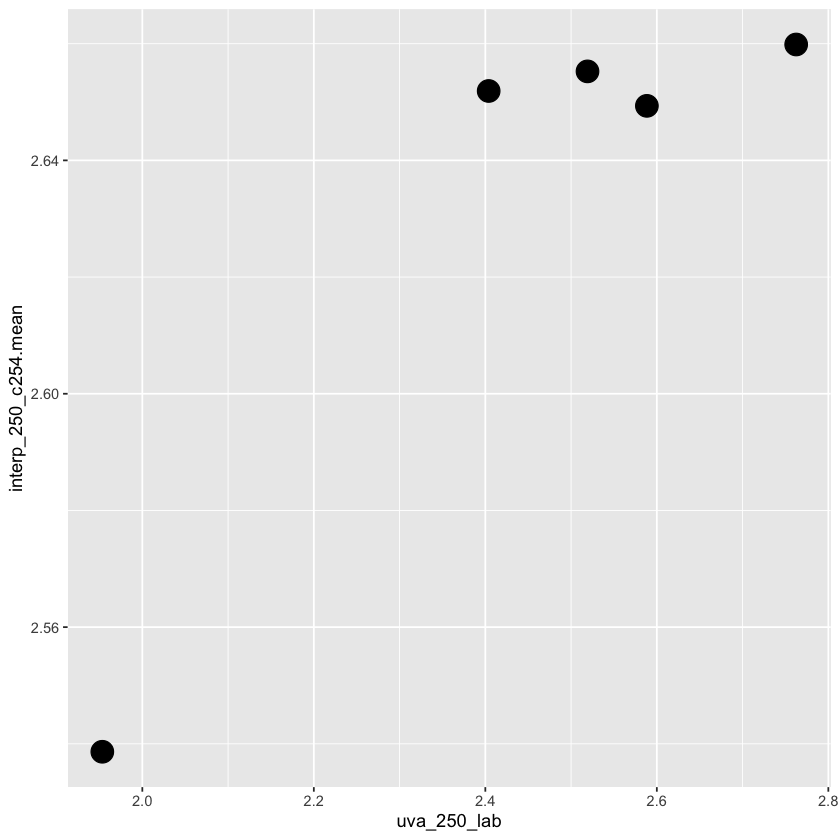

In [94]:
suna_grab<-subset(suna_grab,uva_250_lab>0.1 & a254.mean<7 & !is.na(turbidity.mean))

suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)

#suna_grab$turb_log
summary(lm(uva_250_lab~a254.mean*turb_log,suna_grab))
#summary(lm(uva_250_lab~interp_250_c254.mean*turb_log,suna_grab))

#suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))

suna_grab[,c("uva_250_lab","interp_250_c254.mean")]
ggplot(suna_grab,aes(uva_250_lab,interp_250_c254.mean))+
#theme_ts_space+
#xlab("\nUV Absorbance at 250 nm (Laboratory)")+
#ylab("UV Absorbance at 250 nm (SUNA Uncorrected)\n")+
geom_point(size=6)



In [50]:
suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)


summary(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))
summary(lm(uva_250_lab~interp_250_c254.mean*turb_log,suna_grab))

suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))


ggplot(suna_grab,aes(uva_250_lab,interp_250_c254.mean,color=pH.mean))+
theme_ts_space+
xlab("\nUV Absorbance at 250 nm (Laboratory)")+
ylab("UV Absorbance at 250 nm (SUNA Uncorrected)\n")+
geom_point(size=6)

ggsave("~/neon_suna/plots/SUGG_250_uncorrected.pdf",width = 20, height = 20, units = "cm")



ggplot(suna_grab,aes(uva_250_lab,interp_250_tcorr_log,color=pH.mean))+
theme_ts_space+
geom_smooth(method="lm",color="grey20")+
xlab("\nUV Absorbance at 250 nm (Laboratory)")+
ylab("UV Absorbance at 250 nm (SUNA Corrected)\n")+
geom_point(size=6)+
ggtitle("Turbidity Corrected")

ggsave("~/neon_suna/plots/SUGG_250_corrected.pdf",width = 20, height = 20, units = "cm")




#summary(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean+sensor_temp.mean,suna_grab))
#summary(lm(uva_280_lab~interp_280_c350.mean*turbidity.mean+sensor_temp.mean,suna_grab))
#summary(lm(uva_280_lab~interp_280_c254.mean*turbidity.mean+sensor_temp.mean,suna_grab))


Call:
lm(formula = uva_250_lab ~ interp_250_log * turb_log, data = suna_grab)

Residuals:
       2        3        4        5        7        8 
-1.65453  0.71119  0.65083 -0.37406  0.69600 -0.02944 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                28.13      61.47   0.458    0.692
interp_250_log            -44.20     103.31  -0.428    0.710
turb_log                 -204.80     489.11  -0.419    0.716
interp_250_log:turb_log   342.87     823.89   0.416    0.718

Residual standard error: 1.465 on 2 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1848,	Adjusted R-squared:  -1.038 
F-statistic: 0.1511 on 3 and 2 DF,  p-value: 0.9206



Call:
lm(formula = uva_250_lab ~ interp_250_c254.mean * turb_log, data = suna_grab)

Residuals:
       2        3        4        5        7        8 
-1.65010  0.71034  0.65467 -0.37487  0.69899 -0.03903 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)
(Intercept)                     21.134     44.875   0.471    0.684
interp_250_c254.mean            -4.907     11.404  -0.430    0.709
turb_log                      -149.261    357.288  -0.418    0.717
interp_250_c254.mean:turb_log   37.723     91.069   0.414    0.719

Residual standard error: 1.464 on 2 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1858,	Adjusted R-squared:  -1.035 
F-statistic: 0.1522 on 3 and 2 DF,  p-value: 0.9199


ERROR: Error in `$<-.data.frame`(`*tmp*`, interp_250_tcorr, value = c(`2` = 1.47227677938903, : replacement has 6 rows, data has 8


In [ ]:
names(SUGG_sw)

# Apply turbidity correction based on lab samples.

In [ ]:
cor_cols<-grep("^interp_",names(SUGG_sw))

uva_250_turb_lm<-lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab)

for(i in 1:length(cor_cols)){
	prepdata<-data.frame(interp_250_log=log10(SUGG_sw[,cor_cols[i]]),turbidity.mean=SUGG_sw$turbidity.mean)
	turb_cor_pred<-predict(uva_250_turb_lm,newdata=prepdata)
	SUGG_sw[,c(paste(names(SUGG_sw)[cor_cols[i]],"_turb",sep=""))]<-turb_cor_pred
}



In [ ]:
head(SUGG_sw)

In [ ]:
SUGG_swt_0<-SUGG_sw[,grep("*_turb$",names(SUGG_sw))]
SUGG_swt<-bind_cols(SUGG_sw[,c("dtpr","nitrate.mean","nitrate_mgl.mean","a254.mean","a350.mean","sensor_temp.mean","specificConductance.mean","dissolvedOxygen.mean","pH.mean","chlorophyll.mean","turbidity.mean","fDOM.mean")],SUGG_swt_0)





# Adding PAR data.

In [ ]:
SUGG_par<-loadByProduct(dpID="DP1.20042.001",site="SUGG",check.size=F)
saveRDS(SUGG_par,paste(getwd(),"/SUGG_par.rds",sep=""))
SUGG_par<-readRDS(paste(getwd(),"/SUGG_par.rds",sep=""))




In [ ]:
#lubridate::round_date(SUGG_parts$dtp, "15 minutes")


In [ ]:

SUGG_parts<-SUGG_par$PARWS_5min
SUGG_parts$dtp<-SUGG_parts$startDateTime
#str(SUGG_wqk)



SUGG_parts$dtpr<-lubridate::round_date(SUGG_parts$dtp, "15 minutes")
SUGG_parts_red<-summaryBy(PARMean~dtpr,SUGG_parts,FUN=c(mean))
head(SUGG_parts_red)
#str(SUGG_wq_red)

SUGG_swtpar<-merge(SUGG_swt,SUGG_parts_red,by="dtpr",all.x=TRUE)


In [ ]:

str(SUGG_swtpar$dtpr)

attr(SUGG_swtpar$dtpr,"tzone") <- "Etc/GMT+5"

str(SUGG_swtpar$dtpr)
SUGG_swtpar$date<-as.Date(SUGG_swtpar$dtpr,tz="Etc/GMT+5")

SUGG_dates<-unique(SUGG_swtpar$date)

for(i in 1:length(SUGG_dates)){
    
    
}

In [ ]:

#SUGGd<-subset(SUGG_swtpar,date==as.Date("2019-06-10"))
SUGGd<-SUGG_swtpar

SUGGdk<-SUGGd[,grep("*c254.mean_turb$",names(SUGGd))]
SUGGdk$dtpr<-SUGGd$dtpr

SUGGdm<-subset(melt(SUGGdk,id.vars=c("dtpr")),!is.na(value))
SUGGdm$wavelength<-gsub("interp_","",SUGGdm$variable,fixed=TRUE)
SUGGdm$wavelength<-as.numeric(gsub("_c254.mean_turb","",SUGGdm$wavelength,fixed=TRUE))



str(SUGGdm)

# Trying some ridge plots to look at wavelength changes over time.
So far not looSUGG super great.

In [ ]:
#library(ggridges)
#scales::rescale(height)
#SUGGdm$dtprn<-scales::rescale(as.numeric(SUGGdm$dtpr))
#SUGGdm$abs<-scales::rescale(as.numeric(SUGGdm$value))


#ggplot(subset(SUGGdm,wavelength>=275&wavelength<=295),aes(x = wavelength, y = dtprn, group=dtprn,height = abs)) +
#  geom_ridgeline(fill="grey80",alpha=0.6)

#ggsave("~/neon_suna/plots/SUGGdm_ridge.pdf",width = 20, height = 40, units = "cm")


# Calculating spectral slope 275-295nm on each time step.

In [ ]:
names(SUGGd)
names(SUGGdm)

In [ ]:
ssm_275_295<-subset(SUGGdm,wavelength>=275&wavelength<=295)
dtps<-unique(ssm_275_295$dtpr)
pb <- progress_bar$new(
	format = "  downloading [:bar] :percent eta: :eta",
	total = length(dtps), clear = FALSE, width= 60)
s275295_comp<-data.frame()


for(i in 1:length(dtps)){
	ssm_now<-subset(ssm_275_295,dtpr==dtps[i])
	
	ssm_now$am1<-ssm_now$value*100*2.3025851
	ssm_now$lnam1<-log(ssm_now$am1)


	if(sum(!is.na(ssm_now$lnam1))>2){
		s275295<-lm(ssm_now$lnam1~ssm_now$wavelength)$coefficients[2]*-1
		}else{s275295<-NA}
		s275295_temp<-data.frame(dtpr=dtps[i],s275295=s275295)
		s275295_comp<-bind_rows(s275295_comp,s275295_temp)
#		pb$tick()
}	
	


In [ ]:
ggplot(subset(ssm_275_295,variable=="interp_275_c254.mean_turb"),aes(dtpr,value))+geom_point()


In [ ]:
ssm_275_295<-subset(SUGGdm,wavelength>=275&wavelength<=295)
dtps<-unique(ssm_275_295$dtpr)
pb <- progress_bar$new(
	format = "  downloading [:bar] :percent eta: :eta",
	total = length(dtps), clear = FALSE, width= 60)
s275295_comp<-data.frame()



	ssm_now<-subset(ssm_275_295,dtpr==dtps[i])
	
	ssm_now$am1<-ssm_now$value*100*2.3025851
	ssm_now$lnam1<-log(ssm_now$am1)


	if(sum(!is.na(ssm_now$lnam1))>2){
		s275295<-lm(ssm_now$lnam1~ssm_now$wavelength)$coefficients[2]*-1
		}else{s275295<-NA}
		s275295_temp<-data.frame(dtpr=dtps[i],s275295=s275295)
		s275295_comp<-bind_rows(s275295_comp,s275295_temp)
#		pb$tick()


In [ ]:
nrow(s275295_comp)
nrow(SUGG_swtpar)
SUGG_swtp_ss<-merge(SUGG_swtpar,s275295_comp,by="dtpr",all.x=TRUE)
saveRDS(SUGG_swtp_ss,paste(data,"SUGG_swtp_ss.rds",sep=""))

In [ ]:
sdates<-unique(as.Date(SUGG_swtp_ss$dtpr,tz="Etc/GMT+5"))

i<-5
comp_df<-data.frame()
#print(i)
start<-as.POSIXct(paste(sdates[i]-1,"22:00",tz="Etc/GMT+5"))
finish<-as.POSIXct(paste(sdates[i]+1,"03:00",tz="Etc/GMT+5"))
SUGGday<-subset(SUGG_swtp_ss,dtpr>=start & dtpr<=finish)
SUGGday<-subset(SUGGday,!is.na(PARMean.mean) & !is.na(s275295))
nrow(SUGGday)
    SUGGday$PAR_roll<-as.numeric(c("NA",rollmean(SUGGday$PARMean.mean,k=3,align=c("center"),na.fill=TRUE),"NA"))
    SUGGday$s275295_roll<-as.numeric(c("NA",rollmean(SUGGday$s275295,k=3,align=c("center"),na.fill=TRUE),"NA"))



    SUGG_night<-subset(SUGGday,PARMean.mean<200)
    night_s275295<-mean(SUGG_night$s275295,na.rm=TRUE)

    
    #SUGGday$baseline<-predict(lm(s275295~dtpr,SUGG_night),SUGGday)
    SUGGday$baseline_roll<-predict(lm(s275295_roll~dtpr,SUGG_night),SUGGday)    
    SUGGday$s275295_bs<-SUGGday$s275295_roll-SUGGday$baseline_roll    
    
    SUGG_night_am<-subset(SUGG_night,hour(dtpr)<=12)
    night_s275295_am<-mean(SUGG_night_am$s275295,na.rm=TRUE)
    
    SUGG_night_pm<-subset(SUGG_night,hour(dtpr)>12)
    night_s275295_pm<-mean(SUGG_night_pm$s275295,na.rm=TRUE)
    
    SUGG_day<-subset(SUGGday,PARMean.mean>=10)
    day_s275295<-mean(SUGG_day$s275295,na.rm=TRUE)

    day_s275295_base_sum<-sum(SUGG_day$s275295_bs,na.rm=TRUE)
    day_PAR_roll_base_sum<-sum(SUGG_day$PAR_roll,na.rm=TRUE)    

    int<-lm(s275295_bs~PAR_roll,SUGG_day)$coef[1]
    slope<-lm(s275295_bs~PAR_roll,SUGG_day)$coef[2]    
    
    SUGG_n_am_time<-nrow(SUGG_night_am)
    SUGG_n_pm_time<-nrow(SUGG_night_pm)
    SUGG_d_time<-nrow(SUGG_day)
    
    temp_df<-data.frame(site="SUGG",date=sdates[i],night_s275295=night_s275295,night_s275295_am=night_s275295_am,night_s275295_pm=night_s275295_pm,day_s275295=day_s275295,day_s275295_base_sum=day_s275295_base_sum,day_PAR_roll_base_sum=day_PAR_roll_base_sum,int=int,slope=slope,SUGG_n_am_time=SUGG_n_am_time,SUGG_n_pm_time=SUGG_n_pm_time,SUGG_d_time=SUGG_d_time)

# Extracting spectral daily slope ratio discrepancy.

In [ ]:
sdates<-unique(as.Date(SUGG_swtp_ss$dtpr,tz="Etc/GMT+5"))

#i<-30
comp_df<-data.frame()
for(i in 1:length(sdates)){
#print(i)
start<-as.POSIXct(paste(sdates[i]-1,"22:00",tz="Etc/GMT+5"))
finish<-as.POSIXct(paste(sdates[i]+1,"03:00",tz="Etc/GMT+5"))
SUGGday<-subset(SUGG_swtp_ss,dtpr>=start & dtpr<=finish)
SUGGday<-subset(SUGGday,!is.na(PARMean.mean) & !is.na(s275295))

if(nrow(SUGGday)>80){
    SUGGday$PAR_roll<-as.numeric(c("NA",rollmean(SUGGday$PARMean.mean,k=3,align=c("center"),na.fill=TRUE),"NA"))
    SUGGday$s275295_roll<-as.numeric(c("NA",rollmean(SUGGday$s275295,k=3,align=c("center"),na.fill=TRUE),"NA"))



    SUGG_night<-subset(SUGGday,PARMean.mean<200)
    night_s275295<-mean(SUGG_night$s275295,na.rm=TRUE)
    
    #SUGGday$baseline<-predict(lm(s275295~dtpr,SUGG_night),SUGGday)
    SUGGday$baseline_roll<-predict(lm(s275295_roll~dtpr,SUGG_night),SUGGday)    
    SUGGday$s275295_bs<-SUGGday$s275295_roll-SUGGday$baseline_roll    
    
    SUGG_night_am<-subset(SUGG_night,hour(dtpr)<=12)
    night_s275295_am<-mean(SUGG_night_am$s275295,na.rm=TRUE)
    
    SUGG_night_pm<-subset(SUGG_night,hour(dtpr)>12)
    night_s275295_pm<-mean(SUGG_night_pm$s275295,na.rm=TRUE)
    
    SUGG_day<-subset(SUGGday,PARMean.mean>=10)
    day_s275295<-mean(SUGG_day$s275295,na.rm=TRUE)

    day_s275295_base_sum<-sum(SUGG_day$s275295_bs,na.rm=TRUE)
    day_PAR_roll_base_sum<-sum(SUGG_day$PAR_roll,na.rm=TRUE)    

    int<-lm(s275295_bs~PAR_roll,SUGG_day)$coef[1]
    slope<-lm(s275295_bs~PAR_roll,SUGG_day)$coef[2]    
    
    SUGG_n_am_time<-nrow(SUGG_night_am)
    SUGG_n_pm_time<-nrow(SUGG_night_pm)
    SUGG_d_time<-nrow(SUGG_day)
    
    temp_df<-data.frame(site="SUGG",date=sdates[i],night_s275295=night_s275295,night_s275295_am=night_s275295_am,night_s275295_pm=night_s275295_pm,day_s275295=day_s275295,day_s275295_base_sum=day_s275295_base_sum,day_PAR_roll_base_sum=day_PAR_roll_base_sum,int=int,slope=slope,SUGG_n_am_time=SUGG_n_am_time,SUGG_n_pm_time=SUGG_n_pm_time,SUGG_d_time=SUGG_d_time)
    comp_df<-bind_rows(comp_df,temp_df)
    }
}




In [ ]:
nrow(comp_df)
head(comp_df)

In [ ]:
    SUGG_day$s275295_bs
ggplot(comp_df,aes(date,day_s275295_base_sum))+
       geom_point(size=2)
ggplot(comp_df,aes(date,day_PAR_roll_base_sum))+
       geom_point(size=2)


ggplot(comp_df,aes(day_PAR_roll_base_sum,day_s275295_base_sum))+
geom_point()


saveRDS(comp_df,paste(data,"comp_df_SUGG.rds",sep=""))

In [ ]:
SUGGday<-subset(SUGG_swtp_ss,as.Date(dtpr,tz="Etc/GMT+5")==as.Date("2019-06-11",tz="Etc/GMT+5"))
nrow(SUGGday)

str(SUGGday$s275295)



ggplot(SUGGday,aes(dtpr,s275295))+
geom_point()


ggplot(SUGGday,aes(dtpr,PARMean.mean))+
geom_point()

ggplot(SUGGday,aes(dtpr,PARMean.mean))+
geom_point()

